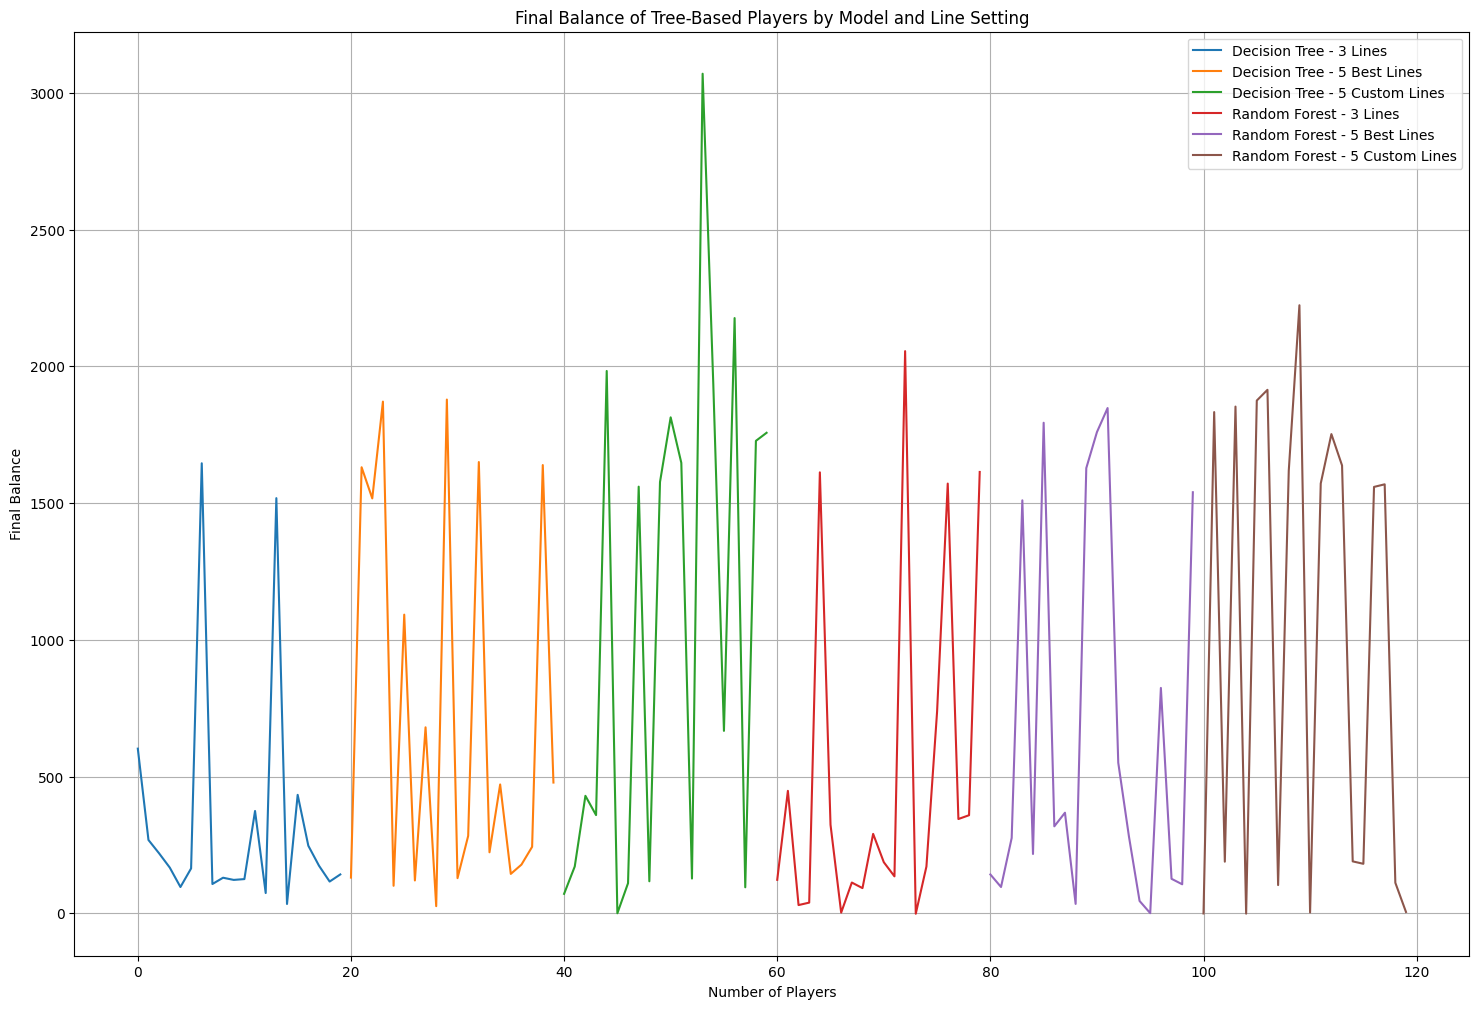

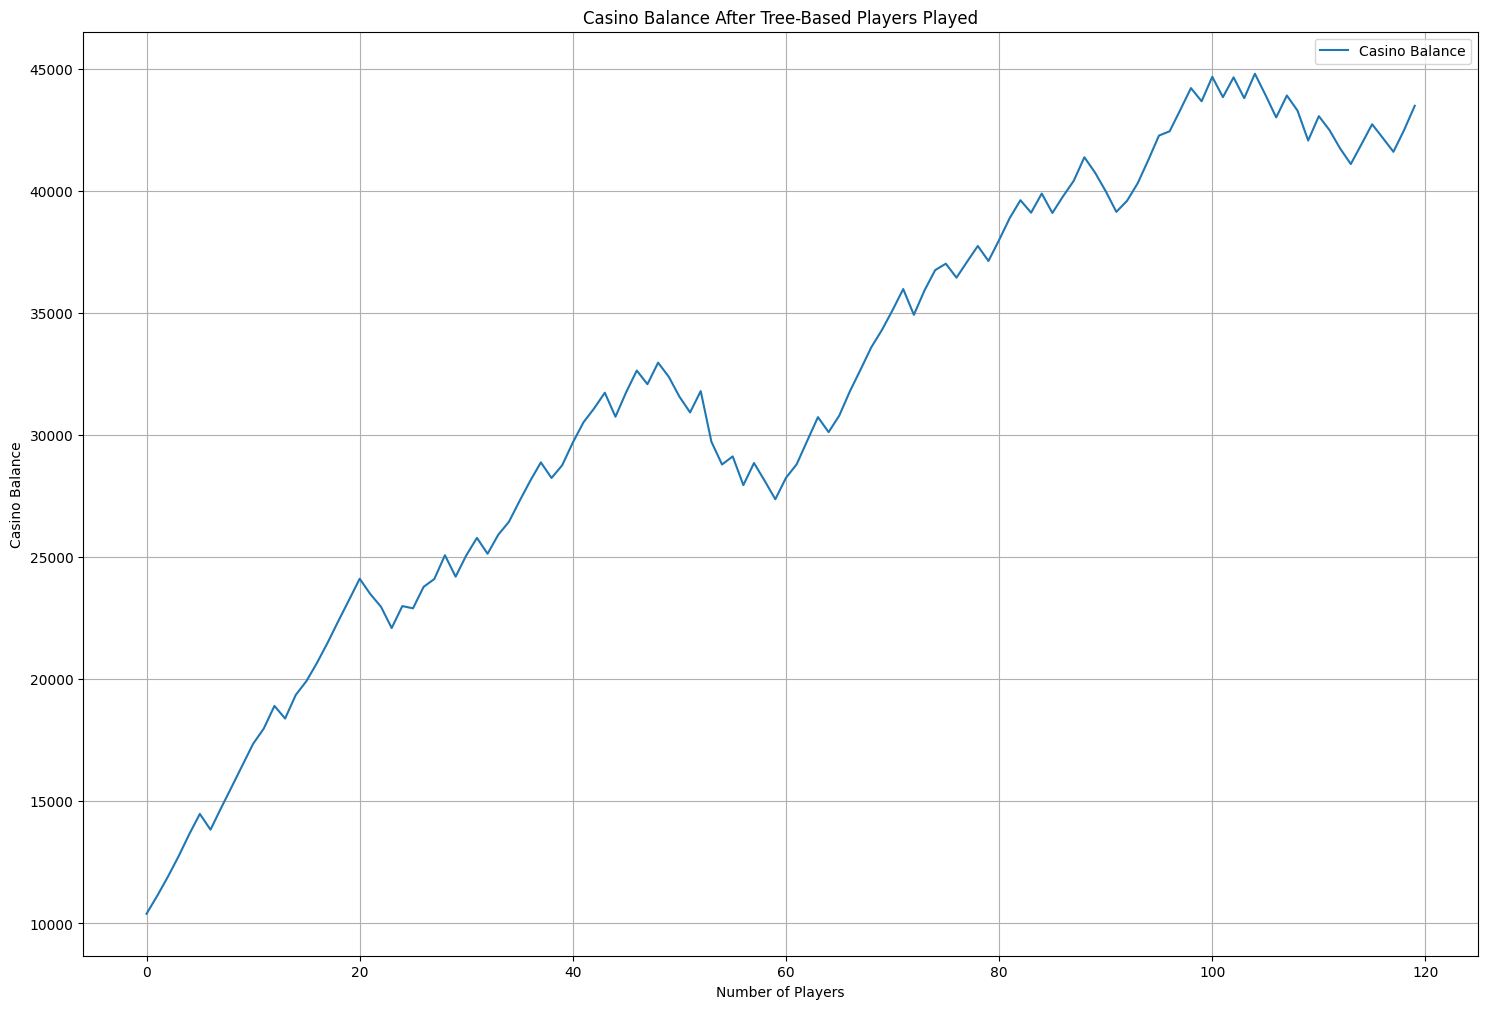

,model,lines,final_balance,casino_balance
0,Decision Tree,3 Lines,602.000,10398.000
1,Decision Tree,3 Lines,268.000,11130.000
2,Decision Tree,3 Lines,219.000,11911.000
3,Decision Tree,3 Lines,167.000,12744.000
4,Decision Tree,3 Lines,96.000,13648.000
...,...,...,...,...
115,Random Forest,5 Custom Lines,180.885,42717.995
116,Random Forest,5 Custom Lines,1559.060,42158.935
117,Random Forest,5 Custom Lines,1568.590,41590.345
118,Random Forest,5 Custom Lines,111.480,42478.865


In [3]:
# Redefine the functions and necessary variables for the complete simulation and plot the output
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

MAX_LINES = 5
MAX_BET = 100
MIN_BET = 1

ROWS = 3
COLS = 3

# Symbol definitions with probabilities and values
symbols = {
    "A": {"count": 1, "value": 20},
    "B": {"count": 3, "value": 15},
    "C": {"count": 5, "value": 10},
    "D": {"count": 7, "value": 8},
    "E": {"count": 9, "value": 5}
}

# Multiplier definitions
multipliers = {
    "A": 3,
    "B": 2.5,
    "C": 2,
    "D": 1.5,
    "E": 1.2
}

# Define custom lines
lines = [
    [(0, 0), (1, 0), (2, 0)],  # Top row
    [(0, 1), (1, 1), (2, 1)],  # Middle row
    [(0, 2), (1, 2), (2, 2)],  # Bottom row
    [(0, 0), (1, 1), (2, 2)],  # Top-left to bottom-right diagonal
    [(2, 0), (1, 1), (0, 2)]   # Bottom-left to top-right diagonal
]

def check_winnings_custom(columns, lines, bet, values, multipliers):
    winnings = 0
    for line in lines:
        symbol = columns[line[0][0]][line[0][1]]
        for position in line:
            if symbol != columns[position[0]][position[1]]:
                break
        else:
            winnings += values[symbol] * bet * multipliers[symbol]
    return winnings

def get_slot_machine_spin(rows, cols, symbols):
    all_symbols = []
    for symbol, symbol_info in symbols.items():
        for _ in range(symbol_info["count"]):
            all_symbols.append(symbol)

    columns = []
    for _ in range(cols):
        column = []
        current_symbols = all_symbols[:]
        for _ in range(rows):
            value = random.choice(current_symbols)
            current_symbols.remove(value)
            column.append(value)
        columns.append(column)

    return columns

# Parameters for tree-based models
num_spins_tree = 100  # Reduced for initial testing
initial_balance_tree = 1000
casino_initial_balance_tree = 10000
num_players_tree = 20  # Reduced for initial testing

# Initialize casino balance
casino_balance_tree = casino_initial_balance_tree

# Data collection for training
train_data = []
train_labels = []

# Simulate data collection
def collect_data(bet_strategy, lines_to_bet):
    balance = initial_balance_tree
    for _ in range(num_spins_tree):
        bet = bet_strategy(balance)
        total_bet = bet * len(lines_to_bet)
        if total_bet > balance:
            continue

        slots = get_slot_machine_spin(ROWS, COLS, symbols)
        winnings = check_winnings_custom(slots, lines_to_bet, bet, {k: v["value"] for k, v in symbols.items()}, multipliers)
        next_balance = balance + winnings - total_bet

        state = [balance, bet, winnings, total_bet]
        reward = next_balance - balance

        train_data.append(state)
        train_labels.append(reward)

        balance = next_balance
        if balance >= initial_balance_tree * 1.5:
            break

def cautious_bet_strategy(balance):
    return max(MIN_BET, min(int(balance * 0.01), MAX_BET))

def aggressive_bet_strategy(balance):
    return min(int(balance * 0.02), MAX_BET)

def random_bet_strategy(balance):
    return max(MIN_BET, min(int(balance * random.uniform(0.01, 0.1)), MAX_BET))

# Line settings
three_lines = lines[:3]
five_lines_best = lines
five_lines_custom = random.sample(lines, 3) + random.sample(lines, 2)

# Collect data for training
for _ in range(num_players_tree):
    collect_data(cautious_bet_strategy, three_lines)
    collect_data(aggressive_bet_strategy, three_lines)
    collect_data(random_bet_strategy, three_lines)

# Convert to numpy arrays
train_data = np.array(train_data)
train_labels = np.array(train_labels)

# Train Decision Tree and Random Forest models
decision_tree_model = DecisionTreeRegressor()
random_forest_model = RandomForestRegressor(n_estimators=100)

decision_tree_model.fit(train_data, train_labels)
random_forest_model.fit(train_data, train_labels)


# Function to simulate tree-based player
def simulate_tree_based_player(start_balance, num_spins, lines_to_bet, model):
    balance = start_balance
    balances = []
    for i in range(num_spins):
        balances.append(balance)
        state = [balance, max(MIN_BET, min(int(balance * 0.01), MAX_BET)), 0, 0]  # Placeholder state
        bet = max(MIN_BET, min(int(balance * 0.01), MAX_BET))
        total_bet = bet * len(lines_to_bet)
        if total_bet > balance:
            continue

        slots = get_slot_machine_spin(ROWS, COLS, symbols)
        winnings = check_winnings_custom(slots, lines_to_bet, bet, {k: v["value"] for k, v in symbols.items()}, multipliers)
        next_balance = balance + winnings - total_bet

        state[2] = winnings
        state[3] = total_bet
        reward = model.predict([state])[0]
        next_balance += reward

        balance = next_balance
        if balance >= start_balance * 1.5:
            break

    return balances, balance

# Initialize casino balance for tree-based models
casino_balance_tree = casino_initial_balance_tree

# Simulate players
results_tree = {
    "model": [],
    "lines": [],
    "final_balance": [],
    "casino_balance": []
}

for model, model_name in [(decision_tree_model, "Decision Tree"), (random_forest_model, "Random Forest")]:
    for line_setting, line_desc in [(three_lines, "3 Lines"), (five_lines_best, "5 Best Lines"), (five_lines_custom, "5 Custom Lines")]:
        for _ in range(num_players_tree):
            balances, final_balance = simulate_tree_based_player(initial_balance_tree, num_spins_tree, line_setting, model)
            casino_balance_tree += (initial_balance_tree - final_balance)
            results_tree["model"].append(model_name)
            results_tree["lines"].append(line_desc)
            results_tree["final_balance"].append(final_balance)
            results_tree["casino_balance"].append(casino_balance_tree)

# Convert results to DataFrame
df_results_tree = pd.DataFrame(results_tree)

# Plot results
plt.figure(figsize=(18, 12))

# Plot player balances
for (model_name, line_desc), group in df_results_tree.groupby(["model", "lines"]):
    plt.plot(group.index, group["final_balance"], label=f"{model_name} - {line_desc}")

plt.xlabel("Number of Players")
plt.ylabel("Final Balance")
plt.title("Final Balance of Tree-Based Players by Model and Line Setting")
plt.legend()
plt.grid(True)
plt.show()

# Plot casino balance
plt.figure(figsize=(18, 12))
plt.plot(df_results_tree["casino_balance"], label="Casino Balance")
plt.xlabel("Number of Players")
plt.ylabel("Casino Balance")
plt.title("Casino Balance After Tree-Based Players Played")
plt.legend()
plt.grid(True)
plt.show()

# Display results
df_results_tree
